In [ ]:
# STEP1 : 주가 데이터 불러오기
# STEP2 : 우량주 선정
# STEP3 : 우량주면 매수
# STEP4 : 매도 타이밍 구현

# 1. 라이브러리 선언

In [84]:
import FinanceDataReader as web

from datetime import date, timedelta

import matplotlib.pyplot as plt

import datetime

import numpy as np

import seaborn as sns

import urllib.parse

import pandas as pd

from matplotlib import font_manager, rc

import platform

from bs4 import BeautifulSoup 

import requests 

# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor # 설명력이 뛰어남
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression   # 위의 3가지를 제일 많이 씀
from sklearn.model_selection import train_test_split
### eda explore Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

MARKET_CODE_DICT = {

    'kospi': 'stockMkt',

    'kosdaq': 'kosdaqMkt',

    'konex': 'konexMkt'

    
}

DOWNLOAD_URL = 'https://kind.krx.co.kr/corpgeneral/corpList.do'

def zeroFill(columnValue):

    columnValue = str(columnValue)

    outValue = columnValue.zfill(6)

    return outValue

def get_stock_codes(market=None, delisted=False):

    params = {'method': 'download'}

    if market.lower() in MARKET_CODE_DICT:

        ## marketType 키 추가

        params['marketType'] = MARKET_CODE_DICT[market]

        print(market.lower()+" market key is exist")

    else:

        print("invalid market")

    # make url  key=value & key = value

    params_string = urllib.parse.urlencode(params)

    print(params_string)
    request_url = DOWNLOAD_URL+"?"+params_string
    
    print(request_url)

    df = pd.read_html(request_url)[0]
    

    df["종목코드"] = df.종목코드.apply(zeroFill)
#     df["종목코드"] = df.종목코드.map('{:06d}'.format) # 동일 결과
 
    return df

In [64]:
# 업체의 재무재표 불러오는 로직
def get_stock_info(stockName=None):
    
    try:
        url = 'https://finance.naver.com/item/main.nhn'
        stocks = get_stock_codes('kospi')
        target_stock = stocks.loc[stocks['회사명'] == stockName ]
        stock_code = target_stock.iloc[0]['종목코드']

        param_code = {'code': stock_code}

        param_string = urllib.parse.urlencode(param_code)

        request_url = url+"?"+param_string
        print(request_url)




        table_df_list = pd.read_html(request_url, encoding='euc-kr')    # 한글이 깨짐. utf-8도 깨짐. 그래서 'euc-kr'로 설정함  
        table_df = table_df_list[3]
    except Exception as e:
        print(e)
    return table_df

In [70]:
# 우량주 판별 로직 10단계

# 1. 1/PER > (AAA회사채 시장수익률)
# 2. 현재 PER < (5년평균 PER) * 0.4
# 3. 배당수익률 > (AAA회사채 시장수익률) * 0.67
# 4. PBR < 0.67
# 5. 0 < 주가/순유동자산 < 0.67
# 6. 0 < 부채비율 < 100%
# 7. 유동비율 > 200%
# 8. 부채 / 순유동자산 < 2
# 9. 과거 10년간 EPS 연복리 증가율 > 7%
# 10. 과거 10년간 순이익 < 0 횟수 2회 이하

def blue_chip_stock(stockName):
    stock_info = get_stock_info(stockName)
    
    # 2번 현재 PER < (5년평균 PER) * 0.4
    if (stock_info.xs('최근 분기 실적', axis=1).xs(10,axis=0)[-1] < stock_info.xs('최근 연간 실적', axis=1).xs(10,axis=0).mean()*0.4):
        
        # 4 번 PBR < 0.67
        cnt = 0
        for i in range(len(list(stock_info.xs('최근 연간 실적',axis=1).xs(12,axis=0) ))):
                      
            if(list(stock_info.xs('최근 연간 실적',axis=1).xs(12,axis=0))[i] < 0.67):
                cnt += 1
                
        if(cnt == 0):
            
            
            # 10. 과거 10년간 순이익 < 0 횟수 2회 이하
            for j in range(len( list(stock_info.xs('최근 연간 실적',axis=1).xs(4,axis=0) ))):
                cnt = 0
                if(list(stock_info.xs('최근 연간 실적',axis=1).xs(4,axis=0)[j]) < 0):
                    cnt += 1
                   
            if(cnt <= 2):
                   
                   # 9. 과거 10년간 EPS 연복리 증가율 > 7% 
                trueOrFalse = []
                cnt = 0
                for i in range(len (list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0)))-1 ):
                    if ( list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0))[i]*0.07 < list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0))[i+1] ):

                        trueOrFalse.append(True)
                    else :
                        trueOrFalse.append(False)
                        cnt +=1
                if(cnt == 0):
                    print("우량주 입니다")
                    return True
                   
                else:
#                     print(stockName + "은(는) 우량주가 아닙니다") # 9번 끝
                    return False
                   
                   
            else:
#                 print(stockName + "은(는) 우량주가 아닙니다") # 10번 끝
                return False   
                              
        else:
#             print(stockName + "은(는) 우량주가 아닙니다")  # 4번 끝
            return False
        
    else:
#         print(stockName + "는(은) 우량주가 아닙니다" )  # 2번 끝
        return False

In [71]:
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    pass
print(platform.system())

Windows


In [74]:

def stock_chart(stockName,time):
    if blue_chip_stock(stockName) is False:
        print("우량주가 아닙니다. 주가차트 반환")
        stocks = get_stock_codes('kospi')
       
        target_stock = stocks.loc[stocks['회사명'] == stockName]
        stock_code = target_stock.iloc[0]['종목코드']
        
        end = date.today()
        start = date.today() - timedelta(time)
        target = web.DataReader(stock_code, start, end)
        target = target.reset_index()
        target["MA_5"] = target['Close'].rolling(window=5,min_periods=1).mean()
        target["MA_20"] = target['Close'].rolling(window=20,min_periods=1).mean()
        target["MA_60"] = target['Close'].rolling(window=60,min_periods=1).mean()
        target["MA_120"] = target['Close'].rolling(window=120,min_periods=1).mean()
        return target
    if blue_chip_stock(stockName) is True:
        print("우량주입니다. 주가차트 반환")
        stocks = get_stock_codes('kospi')
       
        target_stock = stocks.loc[stocks['회사명'] == stockName]
        stock_code = target_stock.iloc[0]['종목코드']
        
        end = date.today()
        start = date.today() - timedelta(time)
        target = web.DataReader(stock_code, start, end)
        target = target.reset_index()
        target["MA_5"] = target['Close'].rolling(window=5,min_periods=1).mean()
        target["MA_20"] = target['Close'].rolling(window=20,min_periods=1).mean()
        target["MA_60"] = target['Close'].rolling(window=60,min_periods=1).mean()
        target["MA_120"] = target['Close'].rolling(window=120,min_periods=1).mean()
        return target

In [218]:
def predict_stock(stockName,time):
    target = stock_chart(stockName,time)
   

In [219]:
predict_stock('카카오',1000)

kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
https://finance.naver.com/item/main.nhn?code=035720
우량주가 아닙니다. 주가차트 반환
kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt


In [223]:
def handle_stock(stockName,time):
    target = stock_chart(stockName,time)
    buy = False
    sell = False
    ma5 = target.MA_5.mean()
    ma20 = target.MA_20.mean()
    if ma5 > ma20 :
        buy = True
        print('매수고려')
    elif ma5 < ma20 :
        sell = True
        print('매도고려')

In [224]:
handle_stock('카카오',1000)

kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
https://finance.naver.com/item/main.nhn?code=035720
우량주가 아닙니다. 주가차트 반환
kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
매수고려


kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
https://finance.naver.com/item/main.nhn?code=035720
우량주가 아닙니다. 주가차트 반환
kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt


# 종가 예측 부분

In [163]:
stockCorr = target_stock.corr() 

In [200]:
target_stock

,Date,Open,High,Low,Close,Volume,Change,MA_5,MA_20,MA_60,MA_120
0,2018-09-28,24085,24186,23885,23885,229927,-0.012445,23885.0,23885.0,23885.000000,23885.000000
1,2018-10-01,24084,24786,23984,23985,368677,0.004187,23935.0,23935.0,23935.000000,23935.000000
2,2018-10-02,24184,24284,22981,23182,615909,-0.033479,23684.0,23684.0,23684.000000,23684.000000
3,2018-10-04,22982,23182,22279,22480,603136,-0.030282,23383.0,23383.0,23383.000000,23383.000000
4,2018-10-05,22179,22379,21777,21878,479642,-0.026779,23082.0,23082.0,23082.000000,23082.000000
...,...,...,...,...,...,...,...,...,...,...,...
671,2021-06-18,150000,157500,149500,155000,7706345,0.047297,146600.0,130700.0,118016.716667,104977.283333
672,2021-06-21,155500,159500,152000,155000,8324948,0.000000,149100.0,132625.0,118977.600000,105637.533333
673,2021-06-22,158000,159000,155500,159000,4662042,0.025806,152000.0,134675.0,119971.700000,106336.966667
674,2021-06-23,162500,170000,161000,169500,9078797,0.066038,157300.0,137175.0,121165.883333,107125.575000


In [192]:
standardLimit = 0.8
label = ['Close']  # 정답지
# 문제지
features = \
    list(stockCorr.loc[ (abs(stockCorr.Close) > standardLimit) &
                    (stockCorr.Close != 1)].index )

In [193]:
features

['Open', 'High', 'Low', 'MA_5', 'MA_20', 'MA_60', 'MA_120']

In [194]:
features.remove('High')
features.remove('Low')

In [197]:
features

['Open', 'MA_5', 'MA_20', 'MA_60', 'MA_120']

In [205]:


standardIndex = 0.8
trainingDataFeatures = \
    target_stock.loc[target_stock.index <= standardIndex, features]
trainingDataLabel = \
    target_stock.loc[target_stock.index <= standardIndex, label]
testDataFeatures = \
    target_stock.loc[target_stock.index > standardIndex, features]
testDataLabel = \
    target_stock.loc[target_stock.index > standardIndex, label]

print(trainingDataFeatures.shape)
print(trainingDataLabel.shape)
print(testDataFeatures.shape)
print(testDataLabel.shape)

(1, 5)
(1, 1)
(675, 5)
(675, 1)


In [206]:
# 모델선언

    # random_state 를 고정시키지 않으면 예측 값이 계속 바뀜
model_dt = DecisionTreeRegressor(random_state=10)  # depth 는 위아래로 늘어남.
model_rf = RandomForestRegressor(random_state=10)
model_lr = LinearRegression()

In [207]:

# 5. 예측

model_dt_fit = model_dt.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_rf_fit = model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_lr_fit = model_lr.fit(X=trainingDataFeatures, y=trainingDataLabel)



model_dt_predict = model_dt_fit.predict(testDataFeatures)
model_rf_predict = model_rf_fit.predict(testDataFeatures)
model_lr_predict = model_lr_fit.predict(testDataFeatures)


predictValueDf = \
    pd.DataFrame( model_dt_predict, columns = ["PREDICT"])
predictValueRf = \
    pd.DataFrame( model_rf_predict, columns = ["PREDICT"])
predictValueLr = \
    pd.DataFrame( model_lr_predict, columns = ["PREDICT"])



validateDf = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueDf], axis=1)
validateRf = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueRf], axis=1)
validateLr = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueLr], axis=1)


<ipython-input-207-dfdbef97d180>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf_fit = model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)


In [208]:
validateDf

,Close,PREDICT
0,23985,23885.0
1,23182,23885.0
2,22480,23885.0
3,21878,23885.0
4,21577,23885.0
...,...,...
670,155000,23885.0
671,155000,23885.0
672,159000,23885.0
673,169500,23885.0


In [214]:
# 6. 정확도 산출

validateDf["MAPE_DF"] = 1-abs(validateDf.Close-validateDf.PREDICT)/validateDf.Close
validateRf["MAPE_RF"] = 1-abs(validateRf.Close-validateRf.PREDICT)/validateRf.Close
validateLr["MAPE_LR"] = 1-abs(validateLr.Close-validateLr.PREDICT)/validateLr.Close
print("RFR : ",validateRf.MAPE_RF.mean())
print("DTR : " ,validateDf.MAPE_DF.mean())
print("LR : " ,validateLr.MAPE_LR.mean())

RFR :  0.613993288446416
DTR :  0.613993288446416
LR :  0.613993288446416


,Close,PREDICT,MAPE_LR
0,23985,23885.0,0.995831
1,23182,23885.0,0.969675
2,22480,23885.0,0.937500
3,21878,23885.0,0.908264
4,21577,23885.0,0.893034
...,...,...,...
670,155000,23885.0,0.154097
671,155000,23885.0,0.154097
672,159000,23885.0,0.150220
673,169500,23885.0,0.140914


RFR :  0.613993288446416
DTR :  0.613993288446416
LR :  0.613993288446416


C:\Users\kopo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kopo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


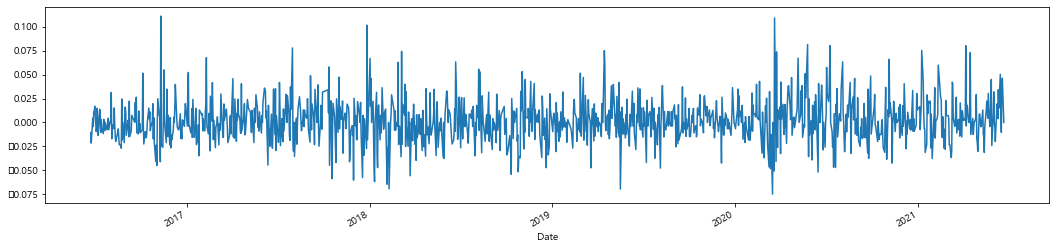

In [13]:
# 수익률 계산로직 부분.

KAKAO_STOCK['Rate'] = np.log( KAKAO_STOCK['Close'].astype(float) / KAKAO_STOCK['Close'].shift(1).astype(float))

KAKAO_STOCK

# 수익률..계산..차트
KAKAO_STOCK["Rate"].plot(figsize=(18,4))
plt.show()